In [56]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
# its a clean dfs
eniac_a = pd.read_csv(r'/Users/deonissx/Documents/01_Bootcamp/03_Projects_WBS/Eniac_ab_test/row_data/eniac_a.csv')
eniac_b = pd.read_csv(r'/Users/deonissx/Documents/01_Bootcamp/03_Projects_WBS/Eniac_ab_test/row_data/eniac_b.csv')
eniac_c = pd.read_csv(r'/Users/deonissx/Documents/01_Bootcamp/03_Projects_WBS/Eniac_ab_test/row_data/eniac_c.csv')
eniac_d = pd.read_csv(r'/Users/deonissx/Documents/01_Bootcamp/03_Projects_WBS/Eniac_ab_test/row_data/eniac_d.csv')

In [18]:
test_a = eniac_a.copy (deep = True)
test_b = eniac_b.copy (deep = True)
test_c = eniac_c.copy (deep = True)
test_d = eniac_d.copy (deep = True)

- Conversion Rate = 2%
- Expected uplift = 20%
- Required number of tested visitors per variation = 19 588
- Average Daily Visitors = 7 142
- Number of Variations = 4
- Required duration in days = 11

Button variation test:
- White “SHOP NOW” (Test A)
- Red “SHOP NOW” (Test B)
- White “SEE DEALS” (Test C)
- Red “SEE DEALS” (Test D)

### Hypothesis

- ##### H<sub>0</sub>: all versions have the same CTR.
- ##### H<sub>a</sub>: there is a difference in the CTR for the different versions.

In [19]:
alpha = 0.05

In [20]:
no_clicks_a = test_a.loc[test_a['Name'] == 'SHOP NOW', 'No. clicks'] # White
no_clicks_b = test_b.loc[test_b['Name'] == 'SHOP NOW', 'No. clicks'] # Red
no_clicks_c = test_c.loc[test_c['Name'] == 'SEE DEALS', 'No. clicks'] # White
no_clicks_d = test_d.loc[test_d['Name'] == 'SEE DEALS', 'No. clicks'] # Red

In [21]:
observed = pd.DataFrame(index=['Clicks', 'Visits'], columns=['A', 'B', 'C', 'D'])

In [22]:
observed.loc["Visits", "A"] = int(test_a["Snapshot information"].str.extract(r"(\d+ visits)").loc[1, 0].split()[0])
observed.loc["Visits", "B"] = int(test_b["Snapshot information"].str.extract(r"(\d+ visits)").loc[1, 0].split()[0])
observed.loc["Visits", "C"] = int(test_c["Snapshot information"].str.extract(r"(\d+ visits)").loc[1, 0].split()[0])
observed.loc["Visits", "D"] = int(test_d["Snapshot information"].str.extract(r"(\d+ visits)").loc[1, 0].split()[0])

In [23]:
observed.loc["Clicks", "A"] = no_clicks_a.sum()
observed.loc["Clicks", "B"] = no_clicks_b.sum()
observed.loc["Clicks", "C"] = no_clicks_c.sum()
observed.loc["Clicks", "D"] = no_clicks_d.sum()

observed.loc["CTR"] = observed.loc["Clicks"] / observed.loc["Visits"] * 100
observed.loc["Not Click"] = observed.loc["Visits"] - observed.loc["Clicks"]

observed

,A,B,C,D
Clicks,512,281,527,193
Visits,25326,24747,24876,25233
CTR,2.021638,1.135491,2.118508,0.764871
Not Click,24814,24466,24349,25040


In [24]:
new_order = ['Visits', 'Clicks', 'Not Click', 'CTR']
observed = observed.reindex(new_order)

observed

,A,B,C,D
Visits,25326,24747,24876,25233
Clicks,512,281,527,193
Not Click,24814,24466,24349,25040
CTR,2.021638,1.135491,2.118508,0.764871


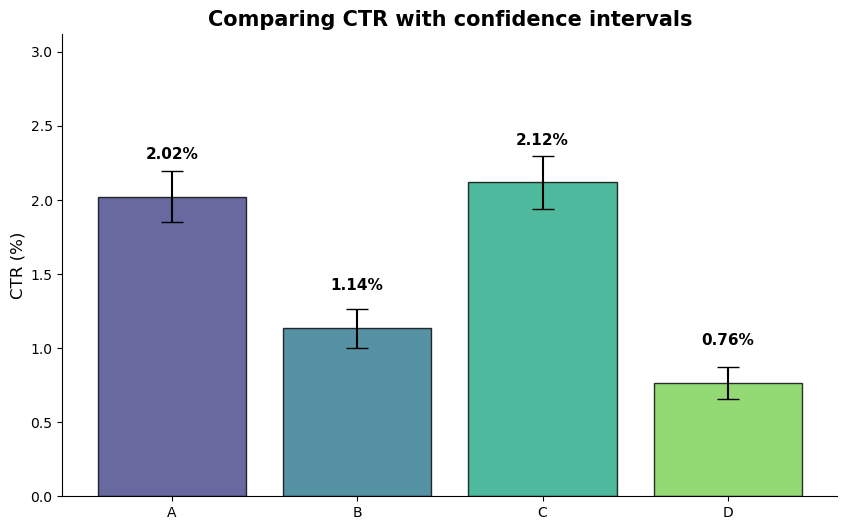

In [52]:
labels = ['A', 'B', 'C', 'D']
ctrs = observed.loc['CTR'].astype(float)
visits = observed.loc['Visits'].astype(float)

p = ctrs / 100
err = 1.96 * np.sqrt(p * (1 - p) / visits) * 100

plt.figure(figsize=(10, 6))
colors = sns.color_palette("viridis", len(labels))

bars = plt.bar(labels, ctrs, yerr=err, capsize=8, color=colors, edgecolor='black', alpha=0.8)

plt.title('Comparing CTR with confidence intervals', fontsize=15, fontweight='bold')
plt.ylabel('CTR (%)', fontsize=12)
plt.ylim(0, ctrs.max() + 1)

for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}%',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 25), textcoords="offset points",
                 ha='center', va='bottom', fontsize=11, fontweight='bold')

sns.despine()
plt.show()

In [25]:
data_for_test = observed.loc[["Clicks", "Not Click"]]
data_for_test = data_for_test.astype(int)

chi2, p, dof, expected = stats.chi2_contingency(data_for_test)
print(f"p-value: {p}")

p-value: 2.7161216607868724e-48


In [32]:
print(f'Alphaa is {alpha}')

Alphaa is 0.05


In [27]:
if p < alpha:
    print("We reject the null hypothesis")
else:
    print("We do not reject the null hypothesis")

We reject the null hypothesis


### Search for the leading value

In [31]:
import itertools

observed_numeric = observed.loc[["Clicks", "Not Click"]].astype(int)
combos = list(itertools.combinations(observed_numeric.columns, 2))
bonferroni_alpha = alpha / len(combos)

for combo in combos:
    pair_data = observed_numeric[list(combo)]
    chi2, p_pair, dof, expected = stats.chi2_contingency(pair_data)
    
    if p_pair < bonferroni_alpha:
        print(f"Combo {combo} shows significance (p={p_pair:.4e})")

Combo ('A', 'B') shows significance (p=2.6731e-15)
Combo ('A', 'D') shows significance (p=3.0809e-33)
Combo ('B', 'C') shows significance (p=6.9555e-18)
Combo ('B', 'D') shows significance (p=2.3573e-05)
Combo ('C', 'D') shows significance (p=6.4505e-37)


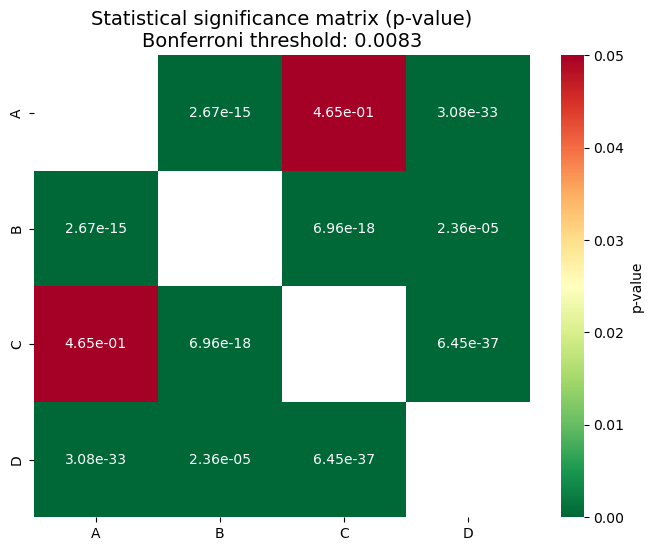

In [53]:
import itertools

observed_numeric = observed.loc[["Clicks", "Not Click"]].astype(int)
variants = observed_numeric.columns

p_matrix = pd.DataFrame(np.nan, index=variants, columns=variants)

combos = list(itertools.combinations(variants, 2))
for combo in combos:
    pair_data = observed_numeric[list(combo)]
    _, p_pair, _, _ = stats.chi2_contingency(pair_data)
    p_matrix.loc[combo[0], combo[1]] = p_pair
    p_matrix.loc[combo[1], combo[0]] = p_pair

plt.figure(figsize=(8, 6))
sns.heatmap(p_matrix, annot=True, fmt=".2e", cmap='RdYlGn_r', 
            cbar_kws={'label': 'p-value'}, vmin=0, vmax=0.05)

plt.title(f'Statistical significance matrix (p-value)\nBonferroni threshold: {bonferroni_alpha:.4f}', fontsize=14)
plt.show()

## CONCLUSION:


The test confirmed a significant advantage of white buttons over red ones. The difference between the "SHOP NOW" and "SEE DEALS" texts in the current data set did not reach statistical significance.

Given the low incoming traffic, continuing the test is not advisable.

It is recommended to retain the current option A, as switching to option C does not guarantee measurable profit gains and requires implementation resources.